In [ ]:
'''Chatgpt Link:https://chatgpt.com/share/67e51b19-1ed0-8003-9246-84c7b2a62de2'''

In [ ]:
'''    1. Hybrid Image Representation using FFT and DCT
    • Apply FFT to extract low-frequency components from Image A.
    • Apply DCT to extract high-frequency components from Image B.
    • Combine the low-frequency and high-frequency components to generate a hybrid image (e.g., visible from different distances).
    • Analyze the perceptual effect of hybrid images at varying resolutions.
        ◦ Downscale and upscale the hybrid image.
        ◦ Observe how different frequencies dominate at different distances.'''

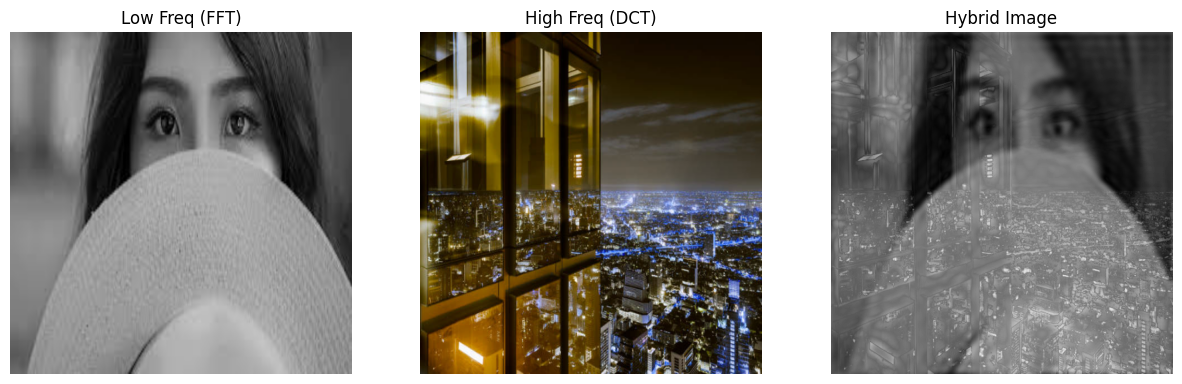

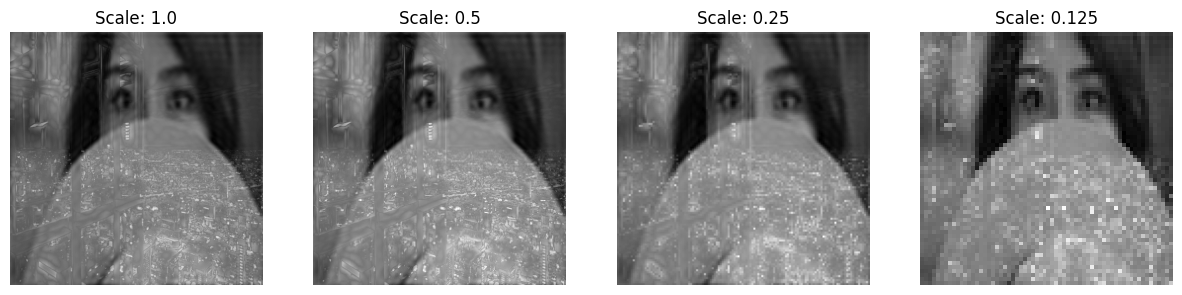

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2, dct, idct

def apply_fft_low_pass(image, cutoff=30):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    f = fft2(gray)
    fshift = np.fft.fftshift(f)
    rows, cols = gray.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    mask[crow - cutoff:crow + cutoff, ccol - cutoff:ccol + cutoff] = 1
    fshift_filtered = fshift * mask
    f_ishift = np.fft.ifftshift(fshift_filtered)
    img_back = np.abs(ifft2(f_ishift))
    return img_back

def apply_dct_high_pass(image, cutoff=30):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    dct_transformed = dct(dct(gray.T, norm='ortho').T, norm='ortho')
    rows, cols = gray.shape
    mask = np.ones((rows, cols), np.uint8)
    mask[:cutoff, :cutoff] = 0
    dct_filtered = dct_transformed * mask
    img_back = idct(idct(dct_filtered.T, norm='ortho').T, norm='ortho')
    return np.abs(img_back)

def create_hybrid_image(imageA, imageB, cutoff_low=30, cutoff_high=30):
    low_frequencies = apply_fft_low_pass(imageA, cutoff_low)
    high_frequencies = apply_dct_high_pass(imageB, cutoff_high)
    hybrid_image = cv2.normalize(low_frequencies + high_frequencies, None, 0, 255, cv2.NORM_MINMAX)
    return hybrid_image.astype(np.uint8)

def display_images(images, titles, figsize=(15, 5)):
    plt.figure(figsize=figsize)
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.show()

def analyze_perception(hybrid_image):
    scales = [1.0, 0.5, 0.25, 0.125]
    resized_images = [cv2.resize(hybrid_image, (0, 0), fx=s, fy=s) for s in scales]
    display_images(resized_images, [f'Scale: {s}' for s in scales])

# Load images (ensure they are the same size)
imageA = cv2.imread(r'/home/student/Downloads/blurred1.jpeg')
imageB = cv2.imread(r'/home/student/Downloads/sharp.jpg')
imageA = cv2.resize(imageA, (512, 512))
imageB = cv2.resize(imageB, (512, 512))

# Generate hybrid image
hybrid_image = create_hybrid_image(imageA, imageB)

# Display results
display_images([imageA, imageB, hybrid_image], ['Low Freq (FFT)', 'High Freq (DCT)', 'Hybrid Image'])

# Analyze perception at different resolutions
analyze_perception(hybrid_image)


In [ ]:
'''    2. Object Detection using SIFT & Haar Wavelets

    •  Apply SIFT feature extraction on an image.
    •  Use Haar-based wavelet decomposition to remove low-energy noise.
    • Perform feature matching between a query image and multiple test images.
    • Compare recognition accuracy before and after noise filtering.'''

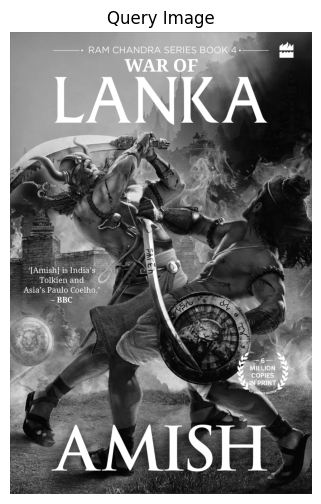

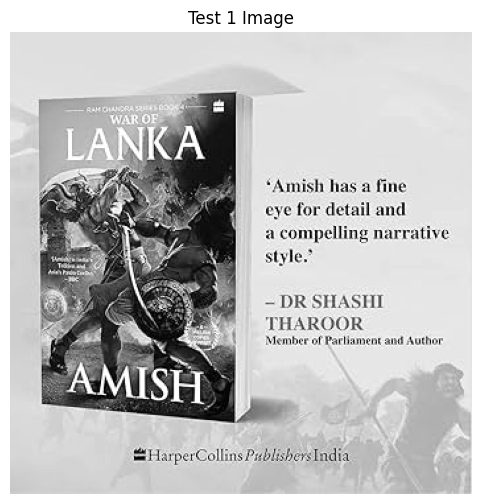

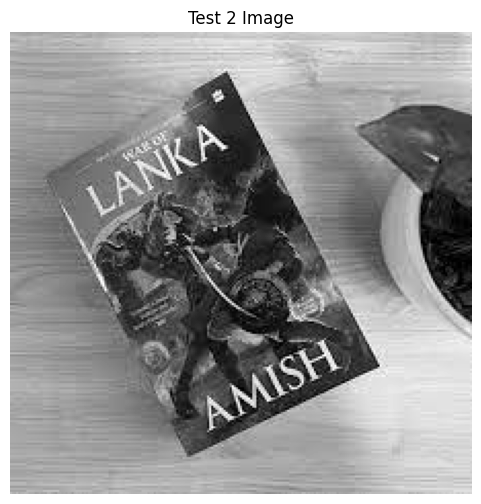

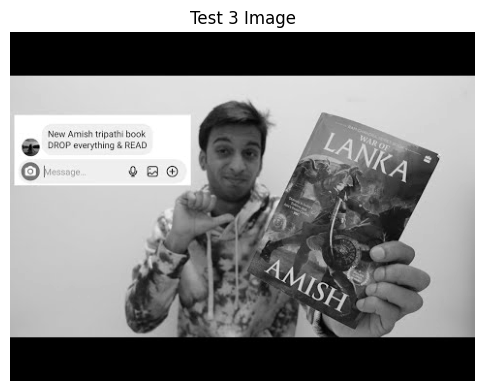

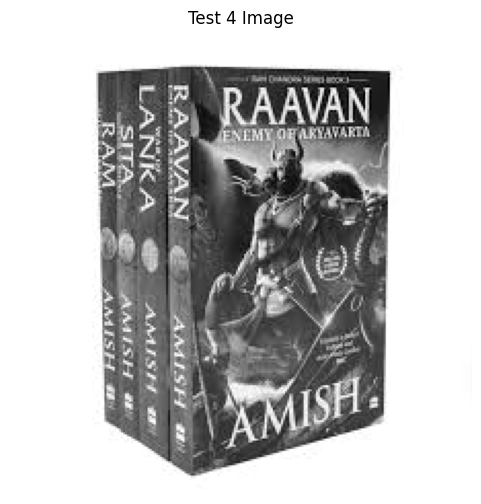

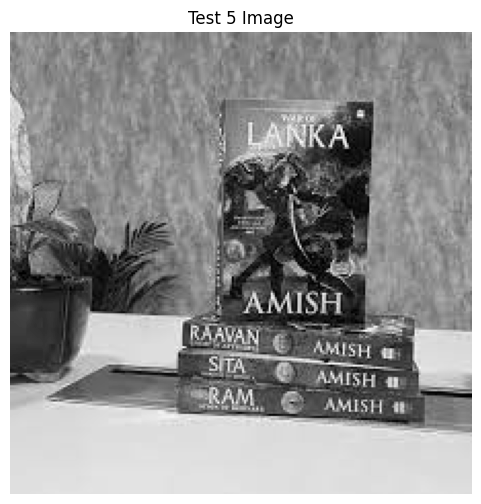

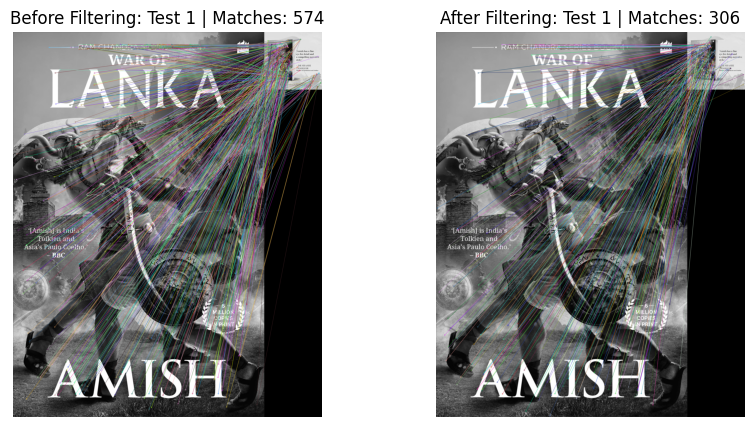

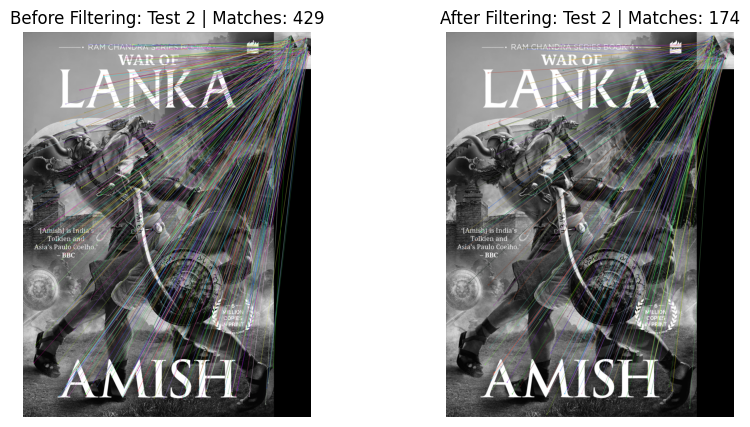

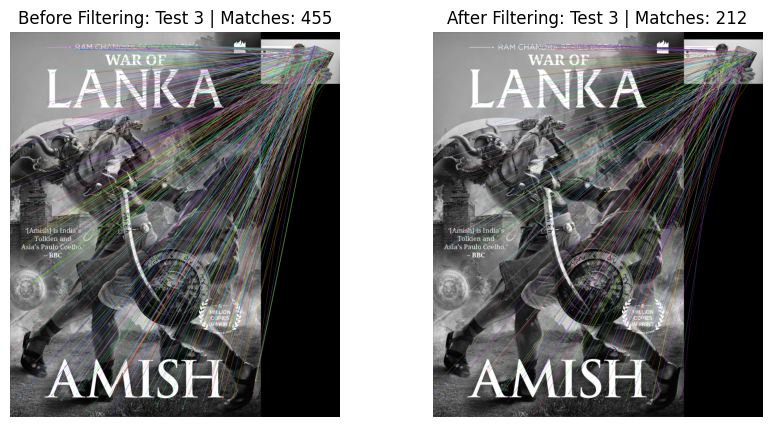

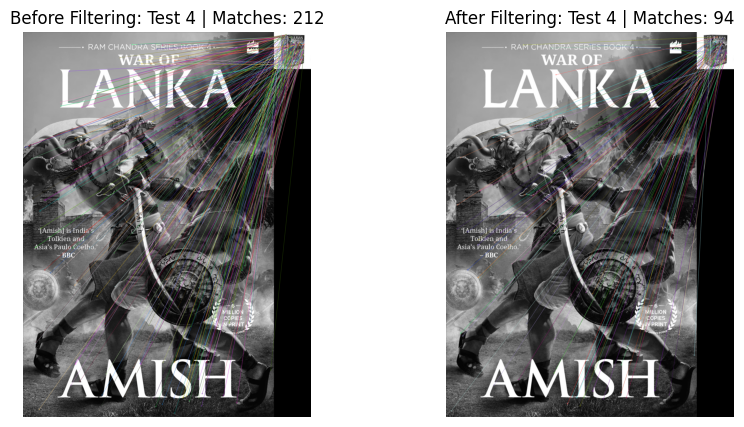

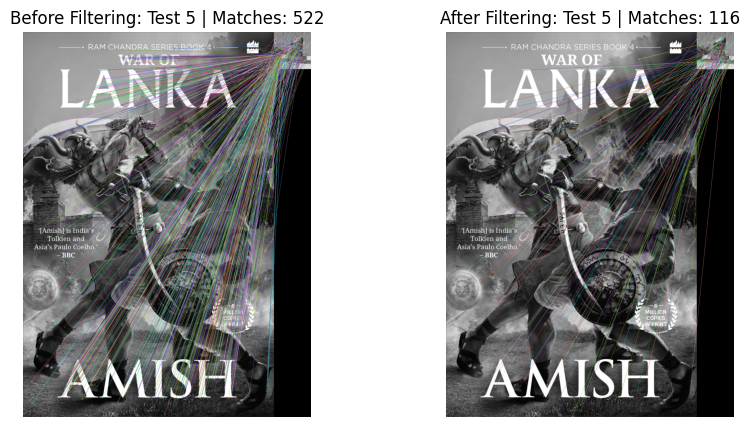

In [4]:
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt

def apply_haar_wavelet(image):
    """
    Applies Haar wavelet decomposition and retains only the Approximation coefficients.
    This reduces noise by filtering out high-frequency components.
    """
    coeffs2 = pywt.dwt2(image, 'haar')
    cA, (cH, cV, cD) = coeffs2  # Approximation, Horizontal, Vertical, Diagonal details
    
    # Retaining only the Approximation coefficients (low-pass filtering)
    image_filtered = pywt.idwt2((cA, (None, None, None)), 'haar')
    
    return np.uint8(image_filtered)

def sift_feature_matching(query_img, test_img):
    """
    Extracts SIFT features from two images and performs feature matching using BFMatcher.
    Returns the matched image and the number of good matches.
    """
    sift = cv2.SIFT_create()
    
    # Detect keypoints and compute descriptors
    kp1, des1 = sift.detectAndCompute(query_img, None)
    kp2, des2 = sift.detectAndCompute(test_img, None)

    # BFMatcher with default parameters
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    
    # Apply Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    
    # Draw matches
    result_img = cv2.drawMatches(query_img, kp1, test_img, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    return result_img, len(good_matches)

# Load the query image in grayscale
query_image = cv2.imread("/home/student/Downloads/main.jpg", cv2.IMREAD_GRAYSCALE)

# Load multiple test images
test_images = [
    "/home/student/Downloads/tests1.jpg",
    "/home/student/Downloads/tests2.jpeg",
    "/home/student/Downloads/tests3.jpg",
    "/home/student/Downloads/tests4.jpeg",
    "/home/student/Downloads/tests5.jpeg"
]

# Display the query image
plt.figure(figsize=(6, 6))
plt.imshow(query_image, cmap='gray')
plt.title("Query Image")
plt.axis("off")
plt.show()

# Create lists to store results
match_results_before = []
match_results_after = []
match_counts_before = []
match_counts_after = []

# Process each test image
for idx, test_image_path in enumerate(test_images):
    test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
    
    if test_image is None:
        print(f"Error: Could not read Test {idx + 1}")
        continue

    # Display each test image before processing
    plt.figure(figsize=(6, 6))
    plt.imshow(test_image, cmap='gray')
    plt.title(f"Test {idx + 1} Image")
    plt.axis("off")
    plt.show()

    # Apply Haar Wavelet filtering
    filtered_query = apply_haar_wavelet(query_image)
    filtered_test = apply_haar_wavelet(test_image)

    # Perform SIFT feature matching before filtering
    match_before, count_before = sift_feature_matching(query_image, test_image)
    match_results_before.append(match_before)
    match_counts_before.append(count_before)

    # Perform SIFT feature matching after filtering
    match_after, count_after = sift_feature_matching(filtered_query, filtered_test)
    match_results_after.append(match_after)
    match_counts_after.append(count_after)

# Display feature matching results before and after filtering
for i in range(len(match_results_before)):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(match_results_before[i])
    plt.title(f"Before Filtering: Test {i+1} | Matches: {match_counts_before[i]}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(match_results_after[i])
    plt.title(f"After Filtering: Test {i+1} | Matches: {match_counts_after[i]}")
    plt.axis("off")

    plt.show()
